### 1. Importações e Definições Iniciais

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# Define os tempos de travessia para cada pessoa ("pessoa: tempo em minutos").
tempos_travessia = {'A': 1, 'B': 2, 'C': 5, 'D': 10}

# Define o estado inicial: todas as pessoas e a tocha no lado inicial.
estado_inicial = (frozenset(['A', 'B', 'C', 'D']), 'inicio')

# Define o estado objetivo: ninguém no lado inicial e a tocha no lado final.
estado_objetivo = (frozenset(), 'final')

### 2. Funções para Geração do Espaço de Estados

In [2]:
def encontrar_acoes_validas(estado_atual):
    """
    Encontra todas as ações válidas (movimentos) a partir de um estado,
    com a poda de não mover apenas uma pessoa na ida.
    """
    pessoas_inicio, posicao_tocha = estado_atual
    acoes = []

    if posicao_tocha == 'inicio':
        # --- AÇÃO DE IDA (INÍCIO -> FINAL) ---
        # Apenas movimentos de duas pessoas são considerados ótimos na ida.
        for p1, p2 in itertools.combinations(pessoas_inicio, 2):
            novo_pessoas_inicio = pessoas_inicio - {p1, p2}
            custo = max(tempos_travessia[p1], tempos_travessia[p2])
            novo_estado = (novo_pessoas_inicio, 'final')
            acoes.append((novo_estado, custo))
    else:  # posicao_tocha == 'final'
        # --- AÇÃO DE VOLTA (FINAL -> INÍCIO) ---
        # Na volta, mover uma pessoa é necessário para levar a tocha.
        pessoas_final = set(tempos_travessia.keys()) - pessoas_inicio
        for p in pessoas_final:
            novo_pessoas_inicio = pessoas_inicio | {p}
            custo = tempos_travessia[p]
            novo_estado = (novo_pessoas_inicio, 'inicio')
            acoes.append((novo_estado, custo))

    return acoes


def explorar_espaco_estados(estado_inicial):
    """
    Explora todos os estados alcançáveis a partir do estado inicial para
    construir as arestas do grafo do problema.
    """
    fronteira = [estado_inicial]
    visitados = {estado_inicial}
    grafo_transicoes = {}

    while fronteira:
        estado_atual = fronteira.pop(0)
        grafo_transicoes[estado_atual] = []

        if estado_atual == estado_objetivo:
            continue

        acoes = encontrar_acoes_validas(estado_atual)

        for proximo_estado, custo in acoes:
            grafo_transicoes[estado_atual].append({'destino': proximo_estado, 'custo': custo})

            if proximo_estado not in visitados:
                visitados.add(proximo_estado)
                fronteira.append(proximo_estado)

    return grafo_transicoes, visitados

### 3. Funções Utilitárias (Visualização e Exportação)

In [3]:
def visualizar_grafo(grafo):
    """
    Gera e exibe uma visualização do grafo de estados.
    """
    G = nx.DiGraph()
    edge_labels = {}

    def formatar_label_no(estado):
        pessoas, tocha = estado
        pessoas_inicio_str = ",".join(sorted(list(pessoas))) if pessoas else "{}"
        pessoas_finais = set(tempos_travessia.keys()) - pessoas
        pessoas_finais_str = ",".join(sorted(list(pessoas_finais)))

        if tocha == 'inicio':
            return f"Início: [{pessoas_inicio_str}] (T)\nFinal: [{pessoas_finais_str}]"
        else:
            return f"Início: [{pessoas_inicio_str}]\nFinal: [{pessoas_finais_str}] (T)"

    for estado_origem, transicoes in grafo.items():
        label_origem = formatar_label_no(estado_origem)
        G.add_node(label_origem)
        for transicao in transicoes:
            estado_destino = transicao['destino']
            custo = transicao['custo']
            label_destino = formatar_label_no(estado_destino)

            G.add_edge(label_origem, label_destino, weight=custo)
            edge_labels[(label_origem, label_destino)] = custo

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, seed=42, k=1.5)

    label_inicial = formatar_label_no(estado_inicial)
    label_objetivo = formatar_label_no(estado_objetivo)
    node_colors = ['skyblue' if node == label_inicial else 'lightgreen' if node == label_objetivo else 'mistyrose' for node in G]

    nx.draw(G, pos, with_labels=True, node_size=5000, node_color=node_colors,
            font_size=9, font_weight='bold', arrowsize=20, edge_color='gray')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred', font_size=9)

    plt.title("Grafo de Estados do Problema da Ponte e Tocha", size=20)
    plt.show()

def salvar_grafo_graphml(grafo_dict, filename):
    """
    Converte o grafo de dicionário para um objeto NetworkX e o salva como GraphML.
    """
    def _estado_para_string(estado):
        pessoas, tocha = estado
        pessoas_str = "".join(sorted(list(pessoas))) if pessoas else "VAZIO"
        return f"inicio={pessoas_str}|tocha={tocha}"

    G_serializavel = nx.DiGraph()

    for estado_origem, transicoes in grafo_dict.items():
        str_origem = _estado_para_string(estado_origem)
        for transicao in transicoes:
            estado_destino = transicao['destino']
            custo = transicao['custo']
            str_destino = _estado_para_string(estado_destino)
            G_serializavel.add_edge(str_origem, str_destino, weight=custo)

    nx.write_graphml(G_serializavel, filename)
    print(f"\nGrafo salvo com sucesso no formato GraphML em '{filename}'")

### 4. Execução Principal e Impressão dos Resultados

In [4]:
print("Iniciando a exploração do espaço de estados do problema da Ponte e Tocha...")
grafo, todos_os_estados = explorar_espaco_estados(estado_inicial)
print(f"\nExploração completa. Total de {len(todos_os_estados)} estados únicos encontrados.")

# Salva o grafo em um arquivo para ser compartilhado
salvar_grafo_graphml(grafo, "grafo_ponte_tocha.graphml")

# Exibe as transições (arestas do grafo)
print("\nAs transições (arestas do grafo) são:\n")
for estado, transicoes in grafo.items():
    pessoas_inicio_str = ", ".join(sorted(list(estado[0]))) if estado[0] else "Ninguém"
    posicao_tocha = estado[1]
    print(f"DO ESTADO: (Pessoas no início: [{pessoas_inicio_str}], Tocha: {posicao_tocha})")

    if not transicoes:
        print("  -> Nenhuma ação possível a partir daqui (estado final).")
    else:
        for transicao in transicoes:
            prox_estado = transicao['destino']
            custo = transicao['custo']
            prox_pessoas_inicio_str = ", ".join(sorted(list(prox_estado[0]))) if prox_estado[0] else "Ninguém"
            prox_posicao_tocha = prox_estado[1]
            print(
                f"  -> VAI PARA: (Pessoas no início: [{prox_pessoas_inicio_str}], Tocha: {prox_posicao_tocha}) com CUSTO: {custo}"
            )
    print("-" * 60)

Iniciando a exploração do espaço de estados do problema da Ponte e Tocha...

Exploração completa. Total de 22 estados únicos encontrados.

Grafo salvo com sucesso no formato GraphML em 'grafo_ponte_tocha.graphml'

As transições (arestas do grafo) são:

DO ESTADO: (Pessoas no início: [A, B, C, D], Tocha: inicio)
  -> VAI PARA: (Pessoas no início: [A, B], Tocha: final) com CUSTO: 10
  -> VAI PARA: (Pessoas no início: [B, C], Tocha: final) com CUSTO: 10
  -> VAI PARA: (Pessoas no início: [A, C], Tocha: final) com CUSTO: 10
  -> VAI PARA: (Pessoas no início: [B, D], Tocha: final) com CUSTO: 5
  -> VAI PARA: (Pessoas no início: [A, D], Tocha: final) com CUSTO: 5
  -> VAI PARA: (Pessoas no início: [C, D], Tocha: final) com CUSTO: 2
------------------------------------------------------------
DO ESTADO: (Pessoas no início: [A, B], Tocha: final)
  -> VAI PARA: (Pessoas no início: [A, B, C], Tocha: inicio) com CUSTO: 5
  -> VAI PARA: (Pessoas no início: [A, B, D], Tocha: inicio) com CUSTO: 10
-

### 5. Visualização do Grafo

Gerando a visualização do grafo...


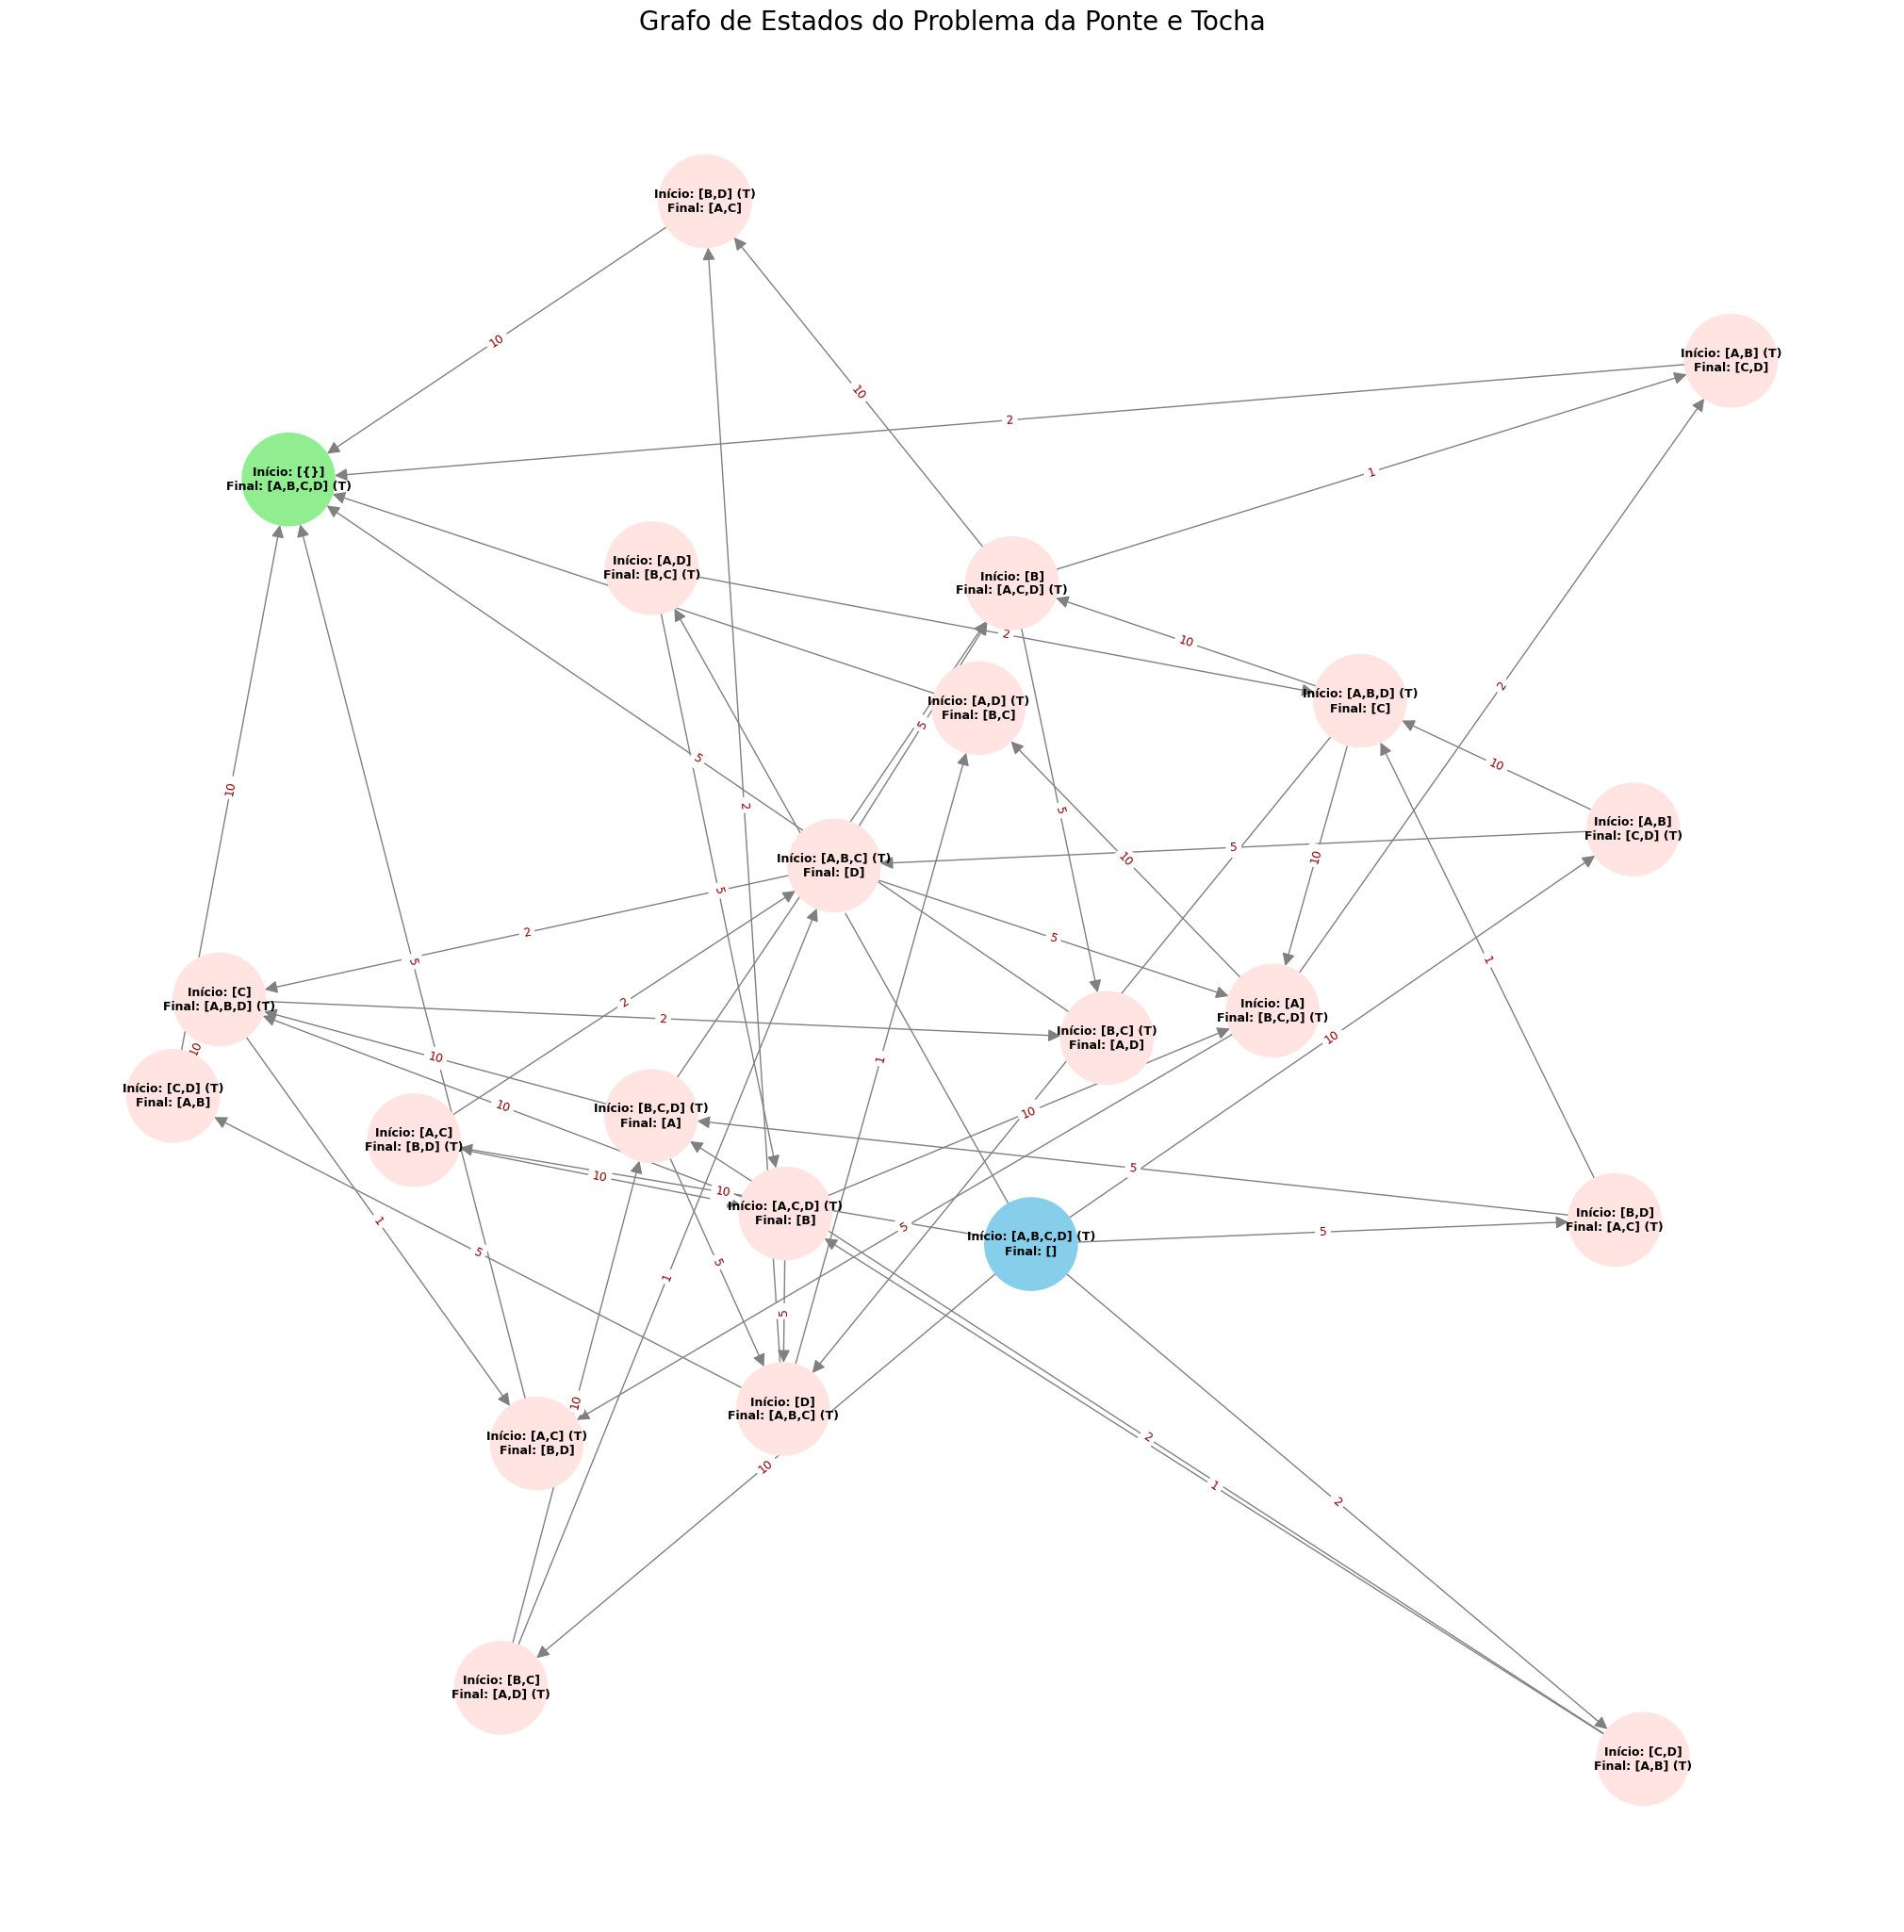

In [5]:
print("Gerando a visualização do grafo...")
visualizar_grafo(grafo)